In [1]:
import numpy as np

In [2]:
np.random.seed(42)

In [3]:
import matplotlib.pyplot as plt

In [4]:
import cv2

In [5]:
def fixColor(image):
    return(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [6]:
label_file = "/cxldata/dlcourse/mask_rcnn_model_data/object_detection_classes_coco.txt"

In [7]:
LABELS = open(label_file).read().strip().split("\n")

In [8]:
COLORS = np.random.randint(0,255,size=(len(LABELS),3),dtype="uint8")

In [9]:
LABELS[:5]

['person', 'bicycle', 'car', 'motorcycle', 'airplane']

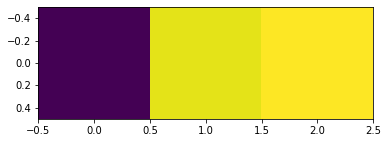

In [10]:
plt.imshow(COLORS[:1])

In [11]:
weights = "/cxldata/dlcourse/mask_rcnn_model_data/mask_rcnn_frozen_inference_graph.pb"

In [12]:
config = "/cxldata/dlcourse/mask_rcnn_model_data/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt"

In [13]:
net = cv2.dnn.readNetFromTensorflow(weights, config)

In [14]:
img = cv2.imread("/cxldata/dlcourse/mask_rcnn_model_data/dining_table.jpg")

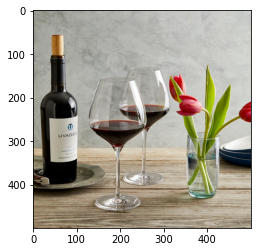

In [15]:
plt.imshow(fixColor(img))

In the context of deep learning, a blob is also the entire image pre-processed and prepared for classification/training. Such pre-processing usually entails mean subtraction and scaling.

In [16]:
blob = cv2.dnn.blobFromImage(img, swapRB=True, crop=False)

In [17]:
net.setInput(blob)

Set blob as input to the network net using setInput.



Detection refers to identifying a bounding box
instance segmentation means identifying the pixels that can belong to the object.
net.forward : Perform a forward pass of the Mask R-CNN. It returns

(1) the bounding box coordinates of the objects in the image along with classID, confidence scores from the output layer named 'detection_out_final' (2) the pixel-wise segmentation for each specific object from the output layer named ‘detection_masks‘.

In [18]:
(boxes,masks_polygons) = net.forward(["detection_out_final","detection_masks"])

In [19]:
boxes.shape

(1, 1, 7, 7)

a. 1 (first dimension): This is the batch size. In our case, we are processing a single image, hence the value is 1.

b. 1 (second dimension): This represents the number of detected objects (or proposals) in the image. Here, only 1 object has been detected by the network.

c. 7 (third and fourth dimensions): These two dimensions refer to the 7x7 feature map generated by the ROI (Region of Interest) pooling. In Mask R-CNN, the detected object’s region is pooled into a 7x7 feature map. This feature map is then used to predict the class, confidence score, and the 4 bounding box coordinates (normalized values).

masks_polygons.shape

100 Detected objects by 1st mask

90 classes found init type of objects

15x15 ploygon has been detected height of ob

masks corresponding to the 100 detections
each detection has 90 classes. (We would be considering the classID whose confidence is greater than threshold).
a matrix denoted as a 15 x 15 mask polygon of the detected objec

### Even here, we could not see 100 objects in our input picture.

Thus, we would only consider the most confident detections (the detections whose confidence score > 0.9 

In [20]:
for i in range(0, boxes.shape[2]): #For each detection
    classID = int(boxes[0, 0, i, 1]) #Class ID
    confidence = boxes[0, 0, i, 2] #Confidence scores
    if confidence > 0.9:
        (H, W) = img.shape[:2]
        box = boxes[0, 0, i, 3:7] * np.array([W, H, W, H]) #Bounding box
        (startX, startY, endX, endY) = box.astype("int")
        boxW = endX - startX
        boxH = endY - startY

(height, width, channels) == img.shape[:2] dont want color channels as opencv does

We shall iterate through each detection using for i in range(0, boxes.shape[2]).
For each detection, we retrieve the classID and confidence score of the detection.
If the confidence value of the detection is greater than the threshold, we consider it as a valid detection and further proceed to create the mask using the correspong mask polygon for this detection, as follows:

Get the height H and width W of the img.
Get the bounding boxes of this valid detection using boxes[0, 0, i, 3:7] and normalize the bounding boxes using boxes[0, 0, i, 3:7] * np.array([W, H, W, H]). Thus the normalized bounding boxes of the currect valid detection is stored in box.
Get the width boxW and height boxH of the bounding box.

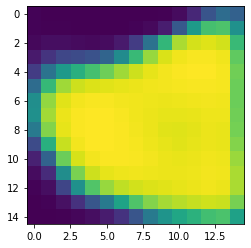

Shape of individual mask (15, 15)


In [21]:
    mask = masks_polygons[i, classID]
    plt.imshow(mask)
    plt.show()
    print("Shape of individual mask", mask.shape)

In [22]:
    mask = cv2.resize(mask, (boxW, boxH), interpolation=cv2.INTER_CUBIC)
    print ("Mask after resize", mask.shape)
    mask = (mask > 0.9)

Mask after resize (344, 83)


In [23]:
    roi = img[startY:endY, startX:endX][mask]


Now, we extract the region of interest (ROI) from the image. It is the overlapping area of the mask in the img.

In [24]:
    color = COLORS[classID]
    blended = ((0.4 * color) + (0.6 * roi)).astype("uint8")
    img[startY:endY, startX:endX][mask] = blended

Now we get the blended form of the color to mark the ROI using this color. This blended color is nothing but the combination of the actual object roi and the random color color we have generated for each classID.
Next, by using img[startY:endY, startX:endX][mask] = blended, we impart this blended color on the ROI of the image, thus forming the view of the object being overlapped with the color of ClassID.

In [25]:
    color = COLORS[classID]
    color = [int(c) for c in color]
    print (LABELS[classID], color)
    cv2.rectangle(img, (startX, startY), (endX, endY), color, 2)
    text = "{}: {:.4f}".format(LABELS[classID], confidence)
    cv2.putText(img, text, (startX, startY - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

bowl [231, 5, 48]


array([[[147, 153, 152],
        [140, 148, 147],
        [135, 143, 142],
        ...,
        [209, 210, 206],
        [209, 210, 206],
        [202, 206, 201]],

       [[146, 152, 151],
        [138, 146, 145],
        [130, 141, 139],
        ...,
        [208, 212, 207],
        [208, 212, 207],
        [207, 208, 204]],

       [[144, 152, 151],
        [134, 145, 143],
        [131, 142, 140],
        ...,
        [210, 211, 207],
        [211, 212, 208],
        [208, 212, 207]],

       ...,

       [[ 35,  58,  90],
        [ 22,  49,  83],
        [ 32,  63, 102],
        ...,
        [174, 190, 197],
        [162, 181, 188],
        [180, 196, 203]],

       [[ 60,  90, 119],
        [ 53,  80, 101],
        [ 66,  93, 120],
        ...,
        [136, 154, 161],
        [158, 177, 184],
        [150, 166, 173]],

       [[ 70, 110, 138],
        [ 63,  93, 120],
        [ 66,  96, 123],
        ...,
        [114, 133, 140],
        [144, 156, 162],
        [142, 156, 162]]

We finally draw the bounding boxes on the img, mark the detect labels along with their corresponding confidence values:
We first get the color corresponding to the ClassID.
Since each color is a representation of 3 values corresponding to R, G, B, we traverse through each of those values and convert them into integer format.
We then draw a rectangle using cv2.rectangle using the coordinate values startX, startY, endX, endY of the bounding boxes of the valid detections.
We then create the text with classID and the confidence value of the detection and write that text on the image using cv2.putText.

In [26]:
threshold = 0.9


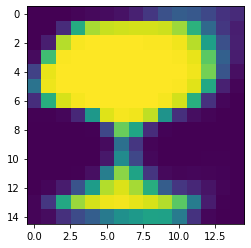

Shape of individual mask (15, 15)
Mask after resize (328, 148)
Mask after threshold (328, 148)
ROI Shape (12764, 3)
wine glass [156, 21, 112]


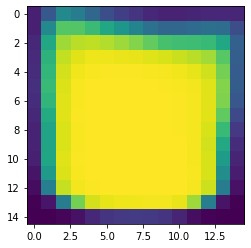

Shape of individual mask (15, 15)
Mask after resize (154, 81)
Mask after threshold (154, 81)
ROI Shape (6072, 3)
vase [166, 56, 167]


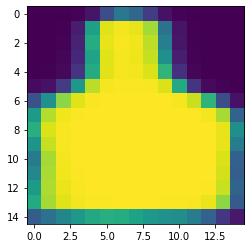

Shape of individual mask (15, 15)
Mask after resize (344, 83)
Mask after threshold (344, 83)
ROI Shape (13497, 3)
bottle [209, 226, 77]


In [27]:
for i in range(0, boxes.shape[2]): #For each detection
    classID = int(boxes[0, 0, i, 1]) #Class ID
    confidence = boxes[0, 0, i, 2] #Confidence scores
    if confidence > threshold:
        (H, W) = img.shape[:2]
        box = boxes[0, 0, i, 3:7] * np.array([W, H, W, H]) #Bounding box
        (startX, startY, endX, endY) = box.astype("int")
        boxW = endX - startX
        boxH = endY - startY

        # extract the pixel-wise segmentation for the object, and visualize the mask       
        mask = masks_polygons[i, classID]
        plt.imshow(mask)
        plt.show()
        print ("Shape of individual mask", mask.shape)

        # resize the mask such that it's the same dimensions of
        # the bounding box, and interpolation gives individual pixel positions
        mask = cv2.resize(mask, (boxW, boxH), interpolation=cv2.INTER_CUBIC)

        print ("Mask after resize", mask.shape)
        # then finally threshold to create a *binary* mask
        mask = (mask > threshold)
        print ("Mask after threshold", mask.shape)
        # extract the ROI of the image but *only* extracted the
        # masked region of the ROI
        roi = img[startY:endY, startX:endX][mask]
        print ("ROI Shape", roi.shape)

        # grab the color used to visualize this particular class,
        # then create a transparent overlay by blending the color
        # with the ROI
        color = COLORS[classID]
        blended = ((0.4 * color) + (0.6 * roi)).astype("uint8")

        # Change the colors in the original to blended color
        img[startY:endY, startX:endX][mask] = blended

        color = COLORS[classID]
        color = [int(c) for c in color]
        print (LABELS[classID], color)
        cv2.rectangle(img, (startX, startY), (endX, endY), color, 2)
        text = "{}: {:.4f}".format(LABELS[classID], confidence)
        cv2.putText(img, text, (startX, startY - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

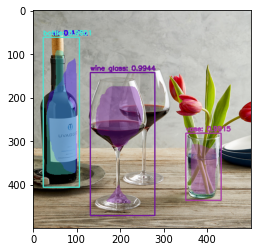

In [28]:
plt.imshow(fixColor(img))